## Offset time-series

@ **Tarapaca, N Chile:** POLYGON((-69.6 -21.8,-67.0 -21.8,-67.0 -20.6,-69.6 -20.6,-69.6 -21.8))

#### SenAT149

Date: 27 Oct 2014 - 28 Feb 2020 (104 acquisitions; [Saved Search at ASF](https://search.asf.alaska.edu/#/?zoom=4.673333333333336&center=-69.344940,-32.388620&polygon=POLYGON((-69.6%20-21.8,-67%20-21.8,-67%20-20.6,-69.6%20-20.6,-69.6%20-21.8))&resultsLoaded=true&maxResults=1000&granule=S1B_IW_SLC__1SDV_20200228T230607_20200228T230635_020475_026CC1_A35E-SLC&productTypes=SLC&beamModes=IW&path=149-149&end=2020-03-01T23:59:00Z))

S1A/B: all S1A before 01 Oct 2016 and all S1B afterwards.

topsStack configuration: [TarapacaSenAT149.txt](https://github.com/yunjunz/notes4proc/blob/master/configs/TarapacaSenAT149.txt)

#### SenDT156

Date: 16 Oct 2014 - 29 Feb 2020 (241 acquisitions; [Saved Search at ASF](https://search.asf.alaska.edu/#/?zoom=4.673333333333336&center=-69.344940,-32.388620&polygon=POLYGON((-69.6%20-21.8,-67%20-21.8,-67%20-20.6,-69.6%20-20.6,-69.6%20-21.8))&resultsLoaded=true&maxResults=1000&granule=S1B_IW_SLC__1SDV_20200229T100032_20200229T100059_020482_026CF5_5634-SLC&productTypes=SLC&beamModes=IW&path=156-156&end=2020-03-01T23:59:00Z))

S1A/B: nicely interleaved S1A/B since July 2017 (to check the S1A/B bias if there is)

topsStack configuration: [TarapacaSenDT156.txt](https://github.com/yunjunz/notes4proc/blob/master/configs/TarapacaSenDT156.txt)

In [57]:
%matplotlib inline
import os
import glob
import shutil
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, network as pnet, readfile, writefile, utils as ut, isce_utils
from mintpy import view

proj_name = 'SenAT149'  # SenAT149, SenDT156

proj_dir = os.path.join('/Users/yunjunz/data/Tarapaca', proj_name)
os.chdir(proj_dir)
print('Go to directory', proj_dir)

Go to directory /Users/yunjunz/data/Tarapaca/SenAT149


### 1. SLC stack

Generate a stack of coregistered SLC using ISCE/topStack **SLC** workflow by running `run_isce_stack.py` with the configurations above.

### 2. Offset stack

Generate a stack of azimuth / range offset using `PyCuAmpcor/examples/cuDenseOffsets.py`.

1. Create `date.list` file (in `merged/SLC` on kamb) as below. Then copy the file to the laptop.

```bash
python -c "import os, glob, numpy as np; vrt_files = sorted(glob.glob('*/*.vrt')); date_list = [os.path.basename(i).split('.')[0] for i in vrt_files]; np.savetxt('../../date.list', date_list, fmt='%s')"
```

2. Create the **water mask** file at full resolution (in `merged/geom_reference` on kamb) as below, so that the multilooked version can be generated during cuDenseOffset.py call.

```bash
createWaterMask.py -d ../../DEM/demLat_N34_N38_Lon_W124_W118.dem.wgs84 -l lat.rdr.full -L lon.rdr.full -o waterMask.rdr.full --fill 0
```

3. Create the `run_files_offset` folder from the cell below. Then copy the `run_files_offset` folder to **kamb** and run each of them in different screen.

In [3]:
kamb_proj_dir = os.path.join('/home/zyunjun/nobak/Tarapaca', proj_name)

## utils function
def get_dense_offset_cmd(proj_dir, date12, gpu_id=None, gen_geometry=False):
    date1, date2 = date12.split('_')
    m_slc = os.path.join(proj_dir, 'merged/SLC/{d}/{d}.slc.full'.format(d=date1))
    s_slc = os.path.join(proj_dir, 'merged/SLC/{d}/{d}.slc.full'.format(d=date2))
    prefix = os.path.join(proj_dir, 'merged/offsets/{d}/offset'.format(d=date12))

    cmd = 'cuDenseOffsets.py -m {m} -s {s} --outprefix {p} '.format(m=m_slc, s=s_slc, p=prefix)
    cmd += ' --kw 300 --kh 100 --nwac 50 --nwdc 1 '
    cmd += ' --ww 256 --wh 128 --sw 10 --sh 10 --raw-osf 2 --corr-osf 64 --redo '
    # generate cropped/multilooked geometry (for one/1st pair only)
    if gen_geometry:
        full_geom_dir = os.path.join(proj_dir, 'merged/geom_reference')
        out_geom_dir = os.path.join(proj_dir, 'merged/offsets/geom_reference')
        cmd += ' --full-geom {} --out-geom {} '.format(full_geom_dir, out_geom_dir)
    # assign GPU ID
    if gpu_id is not None:
        cmd += ' --gpuid {} '.format(gpu_id)

    return cmd

# 1. get date12.list
num_conn = 3
date_list_file = os.path.join(proj_dir, 'date.list')
date_list = np.loadtxt(date_list_file, dtype=bytes, usecols=[0]).astype(str).tolist()
date12_list = pnet.select_pairs_sequential(date_list, num_conn=num_conn, date_format='YYYYMMDD')

# 2.1 prepare run/log_file names and directory
run_files = [os.path.join(proj_dir, 'run_files_offset/run_offset_gpu_{}.sh'.format(i)) for i in gpu_ids]
log_files = [os.path.join(kamb_proj_dir, 'run_files_offset/run_offset_gpu_{}.log'.format(i)) for i in gpu_ids]
run_dir = os.path.dirname(run_files[0])
if not os.path.isdir(run_dir):
    os.makedirs(run_dir)
    print('create directory: {}'.format(run_dir))

# 2.2 job info
num_pair = len(date12_list)
print('number of jobs: {}'.format(num_pair))
gpu_ids = [str(i) for i in [2,3,4,5,6,7]]
num_gpu = len(gpu_ids)
print('number of GPUs: {}'.format(num_gpu))
num_job_per_gpu = np.ceil(num_pair / num_gpu).astype(int)
print('number of jobs per GPU: {}'.format(num_job_per_gpu))

# 2.3 write to run_file: command to create log file
fs = []
for i in range(num_gpu):
    f = open(run_files[i], 'w')
    print('open  file: {} with w mode'.format(run_files[i]))

    cmd = 'touch {}'.format(log_files[i])
    f.write(cmd+'\n')
    #print(cmd)
    fs.append(f)

# 2.4 write to run_file: command to run cuDenseOffsets.py
for i in range(num_pair):
    gpu_ind = int(i / num_job_per_gpu)
    log_file = log_files[gpu_ind]

    if i == 0:
        gen_geometry = True
    else:
        gen_geometry = False
    cmd = get_dense_offset_cmd(kamb_proj_dir,
                               date12=date12_list[i],
                               gpu_id=gpu_ids[gpu_ind],
                               gen_geometry=gen_geometry)
    cmd += ' | tee -a {}'.format(log_file)

    f = fs[gpu_ind]
    f.write(cmd+'\n')
    #print(cmd)

# 2.5 close run_file object and change permission to executables
for i in range(num_gpu):
    # close file
    fs[i].close()
    print('close file:', run_files[i])
    # change permission
    cmd = 'chmod +x {}'.format(run_files[i])
    print(cmd)
    os.system(cmd)

number of jobs: 306
number of GPUs: 6
number of jobs per GPU: 51
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_2.sh with w mode
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_3.sh with w mode
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_4.sh with w mode
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_5.sh with w mode
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_6.sh with w mode
open  file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_7.sh with w mode
close file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_2.sh
chmod +x /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_2.sh
close file: /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_3.sh
chmod +x /Users/yunjunz/data/Tarapaca/SenAT149/run_files_offset/run_offset_gpu_3.sh

4. Mask and filter the offset field

+ Copy the `merged/offsets` directory from kamb to laptop, which includes the stack of offsets and corresponding geometries in `merged/offsets/geom_reference`.

+ Run the following for masking and filtering.

In [4]:
off_dir = os.path.join(proj_dir, 'merged/offsets')    # laptop
off_files = glob.glob(os.path.join(off_dir,'*/offset.bip'))
num_file = len(off_files)
print('number of offset files: {}'.format(num_file))

prog_bar = ptime.progressBar(maxValue=num_file)
for i in range(num_file):
    # data file names
    off_file = off_files[i]
    off_dir = os.path.dirname(off_file)
    snr_file = os.path.splitext(off_file)[0] + '_snr.bip'
    # fig file name
    date12 = os.path.basename(off_dir)
    fig_name = os.path.join(os.path.dirname(off_dir), 'pic', 'off_{}.png'.format(date12))
    # cmd
    scp = os.path.expandvars('$ISCE_STACK/stripmapStack/MaskAndFilter.py')
    cmd = '{scp} -d {off} -s {snr} -t 20 -o {out} --save {fig} '.format(scp=scp,
                                                                        off=off_file,
                                                                        snr=snr_file,
                                                                        out=off_dir,
                                                                        fig=fig_name)
    #print(cmd)
    #os.system(cmd)

    date12 = os.path.basename(off_dir)
    prog_bar.update(i+1, suffix=date12)
prog_bar.close()
print('Done.')

number of offset files: 306
[==================================================] 20150928_20151022    0s /     0s 
Done.


### 3. Offset time-series

#### 3.1 Setup MintPy configuration file, _e.g._ `TarapacaSenAT149.txt`

#### 3.2 Estimate time-series

In [49]:
os.chdir(os.path.join(proj_dir, 'mintpyOffset'))
cfg_file = os.path.expanduser(os.path.join('~/tools/notes4proc/configs', 'Tarapaca{}.txt'.format(proj_name)))
cmd = 'smallbaselineApp.py {} --end modify_network'.format(cfg_file)
!{cmd}
!ifgram_inversion.py inputs/ifgramStack.h5 -w no --water-mask waterMask.h5 -i azimuthOffset 
!ifgram_inversion.py inputs/ifgramStack.h5 -w no --water-mask waterMask.h5 -i rangeOffset 
!reference_date.py timeseriesAz.h5 -t smallbaselineApp.cfg
!reference_date.py timeseriesRg.h5 -t smallbaselineApp.cfg
!timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5
!timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5

setenv: Variable name must contain alphanumeric characters.

___________________________________________________________

  /##      /## /##             /##     /#######           
 | ###    /###|__/            | ##    | ##__  ##          
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/ 
          MintPy v1.2.3-59, 2020-10-13
___________________________________________________________

--RUN-at-2020-10-14 21:01:55.848799--
Current directory: /Users/yunjunz/data/Tarapaca/SenAT149/mintpyOffset
Run routine processin

#### 3.2 Prepare mask

The pixel should be:
+ with high temporal coherence
+ in land
+ within the reasonable velocity range

Go to directory /Users/yunjunz/data/Tarapaca/SenAT149/mintpyOffset
number of valid pixels: 28413
number of valid pixels after temp_coh_az: 24973
number of valid pixels after temp_coh_rg: 24941
number of valid pixels after water_mask: 24941
number of valid pixels after velocityAz.h5 with 2 * MAD (0.10 m): 24131
number of valid pixels after velocityRg.h5 with 2 * MAD (0.02 m): 23321
delete exsited file: maskTempCoh.h5
create HDF5 file: maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (123, 231)           with compression=None
finished writing to maskTempCoh.h5


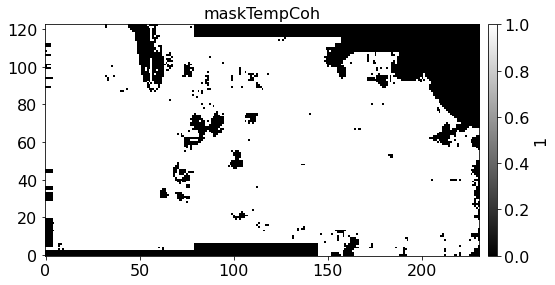

In [50]:
# Go to mintpy directory
mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
os.chdir(mintpy_dir)
print('Go to directory', mintpy_dir)

# use maskTempCoh.h5 as filename as it's used as the default mask file name in smallbaselineApp.py
mask_file = 'maskTempCoh.h5'

## 1. temporal coherence
min_tcoh = 0.999
tcoh_az = readfile.read('temporalCoherenceAz.h5')[0]
tcoh_rg = readfile.read('temporalCoherenceRg.h5')[0]
mask = np.ones(tcoh_az.shape, dtype=np.bool_)
print('number of valid pixels: {}'.format(np.sum(mask)))
mask *= tcoh_az > min_tcoh
print('number of valid pixels after temp_coh_az: {}'.format(np.sum(mask)))
mask *= tcoh_rg > min_tcoh
print('number of valid pixels after temp_coh_rg: {}'.format(np.sum(mask)))

## 2. water mask
water_mask = readfile.read('waterMask.h5')[0]
mask *= water_mask
print('number of valid pixels after water_mask: {}'.format(np.sum(mask)))

## 3. velocity
vel_dev = 0.1 # m/year
for fname in ['velocityAz.h5', 'velocityRg.h5']:
    vel = readfile.read(fname, datasetName='velocity')[0]
    vel_med = np.nanmedian(vel)
    vel_mad = stats.median_absolute_deviation(vel.flatten())
    mask *= (vel - vel_med) < vel_mad * 2
    print('number of valid pixels after {} with 2 * MAD ({:.2f} m): {}'.format(fname, vel_mad, np.sum(mask)))

### for swath 1 only
#xmax = 70
#mask[:,xmax:] = 0

## write to file
atr = readfile.read_attribute('temporalCoherenceAz.h5')
atr['FILE_TYPE'] = 'mask'
atr['DATA_TYPE'] = 'bool'
atr['UNIT'] = '1'
writefile.write(mask, out_file=mask_file, metadata=atr)

# plot
view.main('maskTempCoh.h5 -c gray --noverbose'.split())

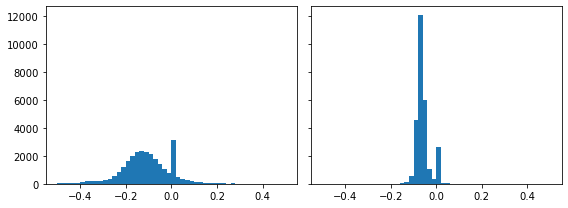

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3], sharey=True)
for ax, fname in zip(axs, ['velocityAz.h5', 'velocityRg.h5']):
    vel = readfile.read(fname, datasetName='velocity')[0]
    ax.hist(vel.flatten(), bins=50, range=[-0.5, 0.5])
fig.tight_layout()
plt.show()

#### 3.3 Add aux info - cross S1A/B, IPF, etc.

In [52]:
def get_S1AB_from_SAFE_file(safe_list_file, ts_file, out_file=None):
    """Get list of Sentinel-1A or Sentinel-1B for each acquisition from the list of SAFE filenames.

    Since not all the SAFE list file are used, due to the bbox argument, ts_file is required to 
    grab the actual dates.

    Parameters: safe_list_file - str, txt file path for the SAFE file names
                ts_file        - str, time-series HDF5 filename
                out_file       - str, output txt file name
    Returns:    dates          - list of str, date in YYYYMMDD format
                sensors        - list of str, A or B
                fnames         - list of str, SAFE filenames
    Examples: 
        !cd ~/nobak/ChileSenAT149
        !ls SLC/S1*.zip > SLC/SAFE.list
        dates, sensors, safe_files = get_s1ab_from_safe_file('SLC/SAFE.list', 'mintpy/timeseries.h5')
    """

    # downloaded SLC files (not all of them are used)
    fnames0 = np.loadtxt(safe_list_file, dtype=bytes, usecols=0).astype(str).tolist()
    fnames0 = [os.path.basename(i) for i in fnames0]

    # get date list
    dates = timeseries(ts_file).get_date_list()

    # get sensors and filenames
    fnames = []
    sensors = []
    for date_str in dates:
        fname = [i for i in fnames0 if date_str in i][0]
        sensor = fname[2]
        fnames.append(fname)
        sensors.append(sensor)

    # output
    if out_file is not None:
        header = 'date \t sensor \t SAFE file'
        np.savetxt(out_file, np.hstack((np.array(dates).reshape(-1,1),
                                        np.array(sensors).reshape(-1,1),
                                        np.array(fnames).reshape(-1,1))),
                   fmt='%s', header=header)
        print('save sensors info to file: {}'.format(out_file))
    return dates, sensors, fnames


def get_IPF(proj_dir, ts_file):

    slaves_dir = os.path.join(proj_dir, 'secondarys')
    master_dir = os.path.join(proj_dir, 'reference')

    # date list
    date_list = timeseries(ts_file).get_date_list()
    num_date = len(date_list)
    # master date
    m_date = [i for i in date_list if not os.path.isdir(os.path.join(slaves_dir, i))][0]

    # grab IPF numver
    IPF_IW1, IPF_IW2, IPF_IW3 = [], [], []
    prog_bar = ptime.progressBar(maxValue=num_date)
    for i in range(num_date):
        date_str = date_list[i]

        # get xml_dir
        if date_str == m_date:
            xml_dir = master_dir
        else:
            xml_dir = os.path.join(slaves_dir, date_str)

        xml_file = os.path.join(xml_dir, 'IW1.xml')
        IPF = isce_utils.load_product(xml_file).processingSoftwareVersion
        IPF_IW1.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW1'.format(date_str))

        xml_file = os.path.join(xml_dir, 'IW2.xml')
        IPF = isce_utils.load_product(xml_file).processingSoftwareVersion
        IPF_IW2.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW2'.format(date_str))

        xml_file = os.path.join(xml_dir, 'IW3.xml')
        IPF = isce_utils.load_product(xml_file).processingSoftwareVersion
        IPF_IW3.append('{:.02f}'.format(float(IPF)))
        prog_bar.update(i+1, suffix='{} IW3'.format(date_str))
    prog_bar.close()
    return date_list, IPF_IW1, IPF_IW2, IPF_IW3

##
safe_list_file = os.path.join(proj_dir, 'SLC/SAFE.list')
ts_file = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')

out_file = os.path.join(proj_dir, 'date.list')
if not os.path.isfile(out_file):
    # calculate S1 sensor and IPF info
    dates, sensors = get_S1AB_from_SAFE_file(safe_list_file, ts_file)[0:2]
    dates, IPF_IW1, IPF_IW2, IPF_IW3 = get_IPF(proj_dir, ts_file)

    # write to text file
    header =  '\t   Sentinel-1 \t\tIPF number\n'
    header += 'date \t\tsensor \tIW1 \tIW2 \tIW3'
    np.savetxt(out_file, np.hstack((np.array(dates).reshape(-1,1),
                                    np.array(sensors).reshape(-1,1),
                                    np.array(IPF_IW1).reshape(-1,1),
                                    np.array(IPF_IW2).reshape(-1,1),
                                    np.array(IPF_IW3).reshape(-1,1),
                                   )),
               fmt='%s', delimiter=' ', header=header)
    print('save sensors info to file: {}'.format(out_file))

# read S1 sensor and IPF info
fc = np.loadtxt(out_file, dtype=bytes, usecols=(0,1,2)).astype(str)
dates   = fc[:,0].tolist()
sensors = fc[:,1].tolist()
IPFs    = fc[:,2].tolist()

# add to h5 metadata
atr_new = dict()
atr_new['SENTINEL1_SENSOR'] = ' '.join(sensors)
atr_new['SENTINEL1_IPF'] = ' '.join(IPFs)

for fname in ['timeseriesRg.h5', 'timeseriesAz.h5']:
    fname = os.path.join(proj_dir, 'mintpyOffset', fname)
    ut.add_attribute(fname, atr_new, print_msg=True)
print('Done.')

SENTINEL1_SENSOR = A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B
SENTINEL1_IPF = 2.45 2.53 2.53 2.53 2.53 2.60 2.60 2.60 2.62 2.62 2.70 2.71 2.71 2.71 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.72 2.82 2.82 2.82 2.82 2.82 2.82 2.82 2.82 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.90 2.90 2.90 2.90 2.90 2.90 2.90 2.90 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 2.91 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.10 3.20 3.20
SENTINEL1_SENSOR = A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B
SENTINEL1_

### 4. Plot time-series results

In [62]:
# plot
os.chdir(os.path.join(proj_dir, 'mintpyOffset'))
!plot_network.py inputs/ifgramStack.h5 -d offsetSNR -v 0 50 --nodisplay
!view.py timeseriesAz.h5 -v -50 50 --title4sen --nodisplay --noverbose
!view.py timeseriesRg.h5 -v -50 50 --title4sen --nodisplay --noverbose
!view.py temporalCoherenceAz.h5 --nodisplay --noverbose
!view.py temporalCoherenceRg.h5 --nodisplay --noverbose
!view.py velocityAz.h5 velocity --nodisplay --noverbose
!view.py velocityRg.h5 velocity --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 azimuthOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 rangeOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 offsetSNR -v 0 200 -c RdBu_truncate --cmap-vlist 0 0.1 1 --nodisplay --noverbose

# move .pdf/png files to pic folder
os.makedirs('./pic', exist_ok=True)
!mv *pdf *png ./pic/

setenv: Variable name must contain alphanumeric characters.
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
['offsetSNRSpatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
offsetSNRSpatialAvg.txt already exists, read it directly
number of acquisitions: 104
number of interferograms: 306
--------------------------------------------------
number of interferograms marked as drop: 101
number of interferograms marked as keep: 205
number of acquisitions marked as drop: 0
max coherence of excluded interferograms: 54.8824
save figure to bperpHistory.pdf
save figure to coherenceMatrix.pdf
save figure to coherenceHistory.pdf
max perpendicular baseline: 196.89 m
max temporal      baseline: 120.0 days
showing coherence
data range: [14.8073, 61.8384]
display range: [0.0, 50.0]
save figure to network.pdf
setenv: Variable name must contain alphanumeric characters.
setenv: Variable name must contain alphanumeric characters.
setenv: Variable 